In [1]:
import torch
torch.cuda.is_available()
print(torch.zeros(1).cuda())

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_sparse import SparseTensor, matmul
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
print(torch_geometric.__version__)

import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType, OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

import networkx as nx
from deepsnap.hetero_graph import HeteroGraph
import copy
from copy import deepcopy
import pickle

import deepsnap
from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from deepsnap.hetero_gnn import forward_op
from deepsnap.hetero_graph import HeteroGraph
from sklearn.metrics import f1_score, roc_auc_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import json
from pathlib import Path as Data_Path
from os import listdir
from os.path import isfile, join
from itertools import combinations
from tqdm.notebook import tqdm

import graph_tool.all as gt
import json
print("graph-tool version: {}".format(gt.__version__.split(' ')[0]))

tensor([0.], device='cuda:0')
2.3.0
graph-tool version: 2.44


In [2]:
import pickle

with open("/home/asa489/Downloads/updated_fixed_graph.pickle", "rb") as f:
    g_nx = pickle.load(f)


In [3]:
mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(g_nx.nodes()))}

# reindex the nodes in the graph
g_nx = nx.relabel_nodes(g_nx, mapping)


In [4]:
# Create a DeepSNAP graph from NetworkX graph
ds_graph = Graph(g_nx)

/home/asa489/.conda/envs/ayush_project/lib/python3.10/site-packages/deepsnap/graph.py:522: UserWarning: Node related key is required.
  warnings.warn("Node related key is required.")


In [5]:
print("Number of vertices:", g_nx.number_of_nodes())
print("Number of edges:", g_nx.number_of_edges())


Number of vertices: 690613
Number of edges: 6655333


In [ ]:
task = 'link_pred'
dataset = GraphDataset([ds_graph], task=task, edge_train_mode='disjoint')
train_ratio, val_ratio, test_ratio = 0.8, 0.1, 0.1
train_dataset, val_dataset, test_dataset = dataset.split(transductive=True, split_ratio=[train_ratio, val_ratio, test_ratio])

In [ ]:
pickle.dump(train_dataset, open('./fixed_graphs/train.graph', 'wb'))

In [ ]:
pickle.dump(val_dataset, open('./fixed_graphs/val.graph', 'wb'))

In [ ]:
pickle.dump(test_dataset, open('./fixed_graphs/test_latest.graph', 'wb'))

In [12]:
train_dataset = pickle.load(open('/home/asa489/fixed_graphs/train.graph', 'rb'))

In [13]:
val_dataset = pickle.load(open('/home/asa489/fixed_graphs/val.graph', 'rb'))

In [ ]:
test_dataset = pickle.load(open('/home/asa489/fixed_graphs/test_latest.graph', 'rb'))

In [19]:
class LGCN_MessagePassing(MessagePassing):
    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, **kwargs):  
        super(LGCN_MessagePassing, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

    def forward(self, x, edge_index, size = None):
        out = self.propagate(edge_index, x=(x, x))
        return out

    def message(self, x_j):
        out = x_j
        return out

    def aggregate(self, inputs, index, dim_size = None):
        node_dim = self.node_dim
        out = torch_scatter.scatter(inputs, index, dim=node_dim, reduce='mean')
        return out

In [20]:
 
    
class LightGCN(torch.nn.Module):
    def __init__(self, train_data, num_layers, emb_size=16):
        super(LightGCN, self).__init__()
        self.convs = nn.ModuleList()
        for l in range(num_layers):
            self.convs.append(LGCN_MessagePassing(0, 0))
        total_nodes = train_data.node_label_index.size()[0]
        self.embeddings = nn.Embedding(total_nodes, emb_size)
        self.loss_fn = nn.BCELoss()
        self.num_layers = num_layers

    def forward(self, data):
        edge_index, edge_label_index, node_label_index = data.edge_index, data.edge_label_index, data.node_label_index
        x = self.embeddings(node_label_index)
        final_emb = x
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            final_emb += x
        final_emb /= self.num_layers
        n1 = torch.index_select(final_emb, 0, edge_label_index[0,:].long())
        n2 = torch.index_select(final_emb, 0, edge_label_index[1,:].long())
        out = torch.sum(n1 * n2, dim=-1) 
        pred = torch.sigmoid(out)
        return torch.flatten(pred)

    def loss(self, pred, label):
        return self.loss_fn(pred, label)


In [21]:
args = {
    'device' : 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_layers' : 4,
    'emb_size' : 32,
    'weight_decay': 1e-6,
    'lr': 0.2,
    'epochs': 50
}

    

In [9]:
input_dim =0
print(input_dim, args)

0 {'device': 'cuda', 'num_layers': 4, 'emb_size': 32, 'weight_decay': 1e-06, 'lr': 0.2, 'epochs': 50}


In [22]:
losses = []

def train(model, optimizer, args):
    val_max = 0
#     best_model = model

    for epoch in range(1, args['epochs'] + 1):
        train_ds.to(args["device"])
        model.train()
        optimizer.zero_grad()
        pred = model(train_ds)
        loss = model.loss(pred, train_ds.edge_label.type(pred.dtype))
        loss.backward()
        optimizer.step()
        score_train, train_loss = test(model, 'train', args)
        val_score, val_loss = test(model, 'val', args)
        print(f'Current Epoch: {epoch}, Train Score: {score_train}, Val Score:{val_score}, Train Loss: {train_loss}, Val Loss: {val_loss}')
        losses.append((train_loss, val_loss))


    return model

def test(model, mode, args):
    model.eval()
    auc_score = 0
    pred_loss = 0

    if mode not in ['train', 'test', 'val']:
        raise ValueError("Invalid mode. Allowed values are 'train', 'test', and 'val'.")
    if mode == 'train':
        data=train_ds
    elif mode == 'test':
        data=test_dataset[0]     
    else:  # mode == 'val'
        data=val_dataset[0]
        
    data.to(args["device"])

    pred = model(data)
    loss = model.loss(pred, data.edge_label.type(pred.dtype))
    auc_score += roc_auc_score(data.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy())
    pred_loss += loss.item()

    return auc_score, pred_loss

In [14]:
train_ds=train_dataset[0]

In [23]:
model = LightGCN(train_ds, args['num_layers'], emb_size=args['emb_size']).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

final_model = train(model, optimizer, args)


Current Epoch: 1, Train Score: 0.5314572241804169, Val Score:0.5133467585237893, Train Loss: 0.7037901282310486, Val Loss: 0.7122864127159119
Current Epoch: 2, Train Score: 0.6272093073932153, Val Score:0.5859605696124262, Train Loss: 0.6725812554359436, Val Loss: 0.6840277314186096
Current Epoch: 3, Train Score: 0.8256590370425548, Val Score:0.7826620732228557, Train Loss: 0.6140472888946533, Val Loss: 0.6277557015419006
Current Epoch: 4, Train Score: 0.9000663140468412, Val Score:0.8789569667083822, Train Loss: 0.5453473925590515, Val Loss: 0.5635173320770264
Current Epoch: 5, Train Score: 0.9073901435920348, Val Score:0.8921130048363617, Train Loss: 0.523812472820282, Val Loss: 0.5466740727424622
Current Epoch: 6, Train Score: 0.9068752593521568, Val Score:0.89312343316958, Train Loss: 0.5119380354881287, Val Loss: 0.5321810841560364
Current Epoch: 7, Train Score: 0.9023196559781084, Val Score:0.8887327652147986, Train Loss: 0.49995338916778564, Val Loss: 0.5146470665931702
Current 

In [18]:
dic=final_model.state_dict()
torch.save(dic, 'model_latest.pt')

In [22]:
input_dim=0
newModel = LightGCN(ds_graph, args['num_layers'], emb_size=args['emb_size'])

newModel.load_state_dict(torch.load('model_latest.pt'))

<All keys matched successfully>

In [23]:
newModel.to(args['device'])
train_auc_score, training_loss = test(newModel, 'train', args)
val_auc_score, validation_loss = test(newModel, 'val', args)
test_auc_score, testing_loss = test(newModel, 'test', args)
print(f'Train Score: {train_auc_score}, Val Score: {val_auc_score}, Test Score: {test_auc_score}, Train Loss: {training_loss}, Val Loss: {validation_loss}, Test Loss: {testing_loss}  ')

Train Score: 0.9017800402045972, Val Score: 0.8985465820746975, Test Score: 0.8963531461107839, Train Loss: 0.5087321996688843, Val Loss: 0.5126386880874634, Test Loss: 0.5146584510803223  


In [16]:
def plot_learning_curve(losses):
    train_loss, val_loss = zip(*losses)
    steps = list(range(1, len(train_loss) + 1))
    
    lowestVal = np.round(np.min(val_loss), 3)
    # train_list = [math.log10(x) for x in train_loss]
    # val_list = [math.log10(x) for x in val_loss]
    
    plt.figure(figsize=(16, 16))
    plt.plot(steps, train_loss, '-r', label='Train Loss')
    plt.plot(steps, val_loss, '-b', label='Val Loss')
    plt.hlines(lowestVal, 1, 50, colors='k', linestyles='dotted', label='Lowest Validation Loss: {}'.format(lowestVal))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.savefig('train_val_loss.png')

    return plt

<module 'matplotlib.pyplot' from '/home/asa489/.conda/envs/ayush_project/lib/python3.10/site-packages/matplotlib/pyplot.py'>

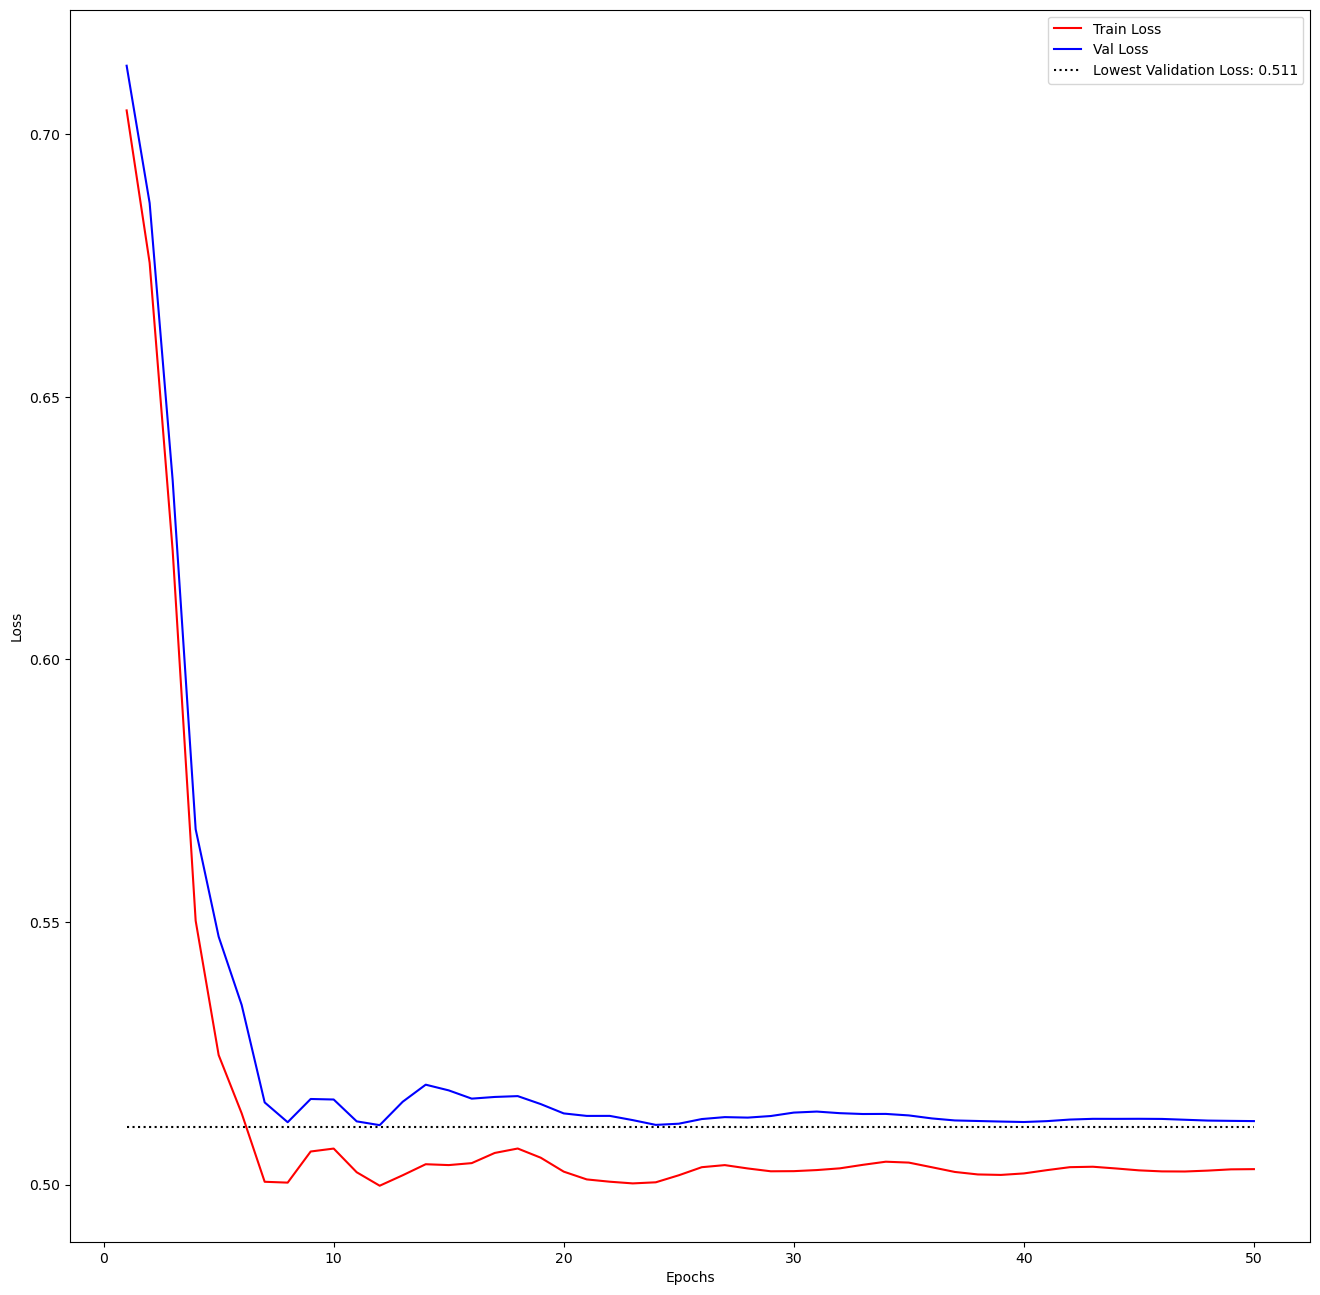

In [17]:
plot_learning_curve(losses)


In [48]:
nodeUri=nx.get_node_attributes(g_nx,'uri')
node_dict = {v: k for k, v in nx.get_node_attributes(g_nx,'uri').items() if v}
nodeId=nx.get_node_attributes(g_nx,'name')
pl_dict={}
for k, v in nx.get_node_attributes(g_nx,'name').items():
    if(v):
        if(v in pl_dict):
            continue
        else:
            pl_dict[v]=k
    
track_nodes=red_nodes = [n for n, d in g_nx.nodes(data=True) if d.get("uri") != ""]
playlist_exist=[]

playlist_node_label=[]
playlist_edge_label=[[],[]]
for u,v in g_nx.edges(100):
    playlist_exist.append(v)

for  x in track_nodes:
    if(x in playlist_exist):
        continue
    else:
        playlist_edge_label[0].append(100)
        playlist_edge_label[1].append(x)
        playlist_node_label.append(0)

node_label_tensor=torch.tensor(playlist_node_label)
edge_label_tensor=torch.tensor(playlist_edge_label)
ds_graph.edge_label_index=edge_label_tensor
ds_graph.edge_index=ds_graph.edge_index.cpu()
ds_graph.edge_label_index=ds_graph.edge_label_index.cpu()
ds_graph.node_label_index=ds_graph.node_label_index.cpu()

In [25]:
pred=newModel(test_dataset[0])


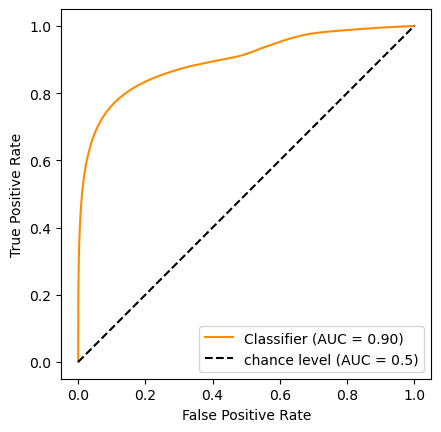

In [32]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(
  test_dataset[0].edge_label.cpu(),
    pred.cpu().detach().numpy(),
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [49]:
newModel.cpu()
pred_ds=newModel(ds_graph)


In [69]:
ls_trUri=[]
for x in ds_graph.edge_label_index[1]:
    ls_trUri.append(g_nx.nodes[x.item()]['uri'])
df_dict={'pred':pred_ds.cpu().detach().numpy(),'Track_node_label':ds_graph.edge_label_index[1].detach().numpy(),'Track_Uri':ls_trUri}
df_rec_list=pd.DataFrame(df_dict)
df_lessthan = df_rec_list[df_rec_list['pred'] > 0.70]
df_lessthan=df_lessthan.sample(frac=1)
uri_list=list(df_lessthan['Track_Uri'])



In [70]:
len(uri_list)

92232

In [71]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

def gettrackname(uri_list):
    # Replace the values below with your own Spotify API credentials
    client_id = 'd5566a60926740f3a8070889731a2d21'
    client_secret = 'eb5fc0638a1241c3a611186ff8d167e3'

    # Initialize the Spotify API client
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    counter=1

    info = []
    for uri in uri_list:
        # Use the track method to get information about the track
        track_info = sp.track(uri)

        # Get the track name from the track information
        track_name = track_info['name']
        track_info = sp.track(uri)
        album=track_info['album']['uri']
        album_info = sp.album(album)
        image_uri=album_info['images'][0]['url']
        preview_url = track_info['preview_url']
        external_url = track_info['external_urls']['spotify']
        # Get the artist name from the track information
        artist_name = track_info['artists'][0]['name']
        info.append((track_name, artist_name, image_uri, preview_url, external_url))
        if(counter>100):
            break
        counter=counter+1
        
    return info

tr_list=gettrackname(uri_list)


Couldn't read cache at: .cache
Couldn't write token to cache at: .cache
Couldn't read cache at: .cache
Couldn't write token to cache at: .cache
Couldn't read cache at: .cache
Couldn't write token to cache at: .cache
Couldn't read cache at: .cache
Couldn't write token to cache at: .cache
Couldn't read cache at: .cache
Couldn't write token to cache at: .cache
Couldn't read cache at: .cache
Couldn't write token to cache at: .cache
Couldn't read cache at: .cache
Couldn't write token to cache at: .cache
Couldn't read cache at: .cache
Couldn't write token to cache at: .cache
Couldn't read cache at: .cache
Couldn't write token to cache at: .cache
Couldn't read cache at: .cache
Couldn't write token to cache at: .cache
Couldn't read cache at: .cache
Couldn't write token to cache at: .cache
Couldn't read cache at: .cache
Couldn't write token to cache at: .cache
Couldn't read cache at: .cache
Couldn't write token to cache at: .cache
Couldn't read cache at: .cache
Couldn't write token to cache at:

In [72]:
columns=['Track Name','Artist Name','Image URI','Preview URL','External URL']
df=pd.DataFrame(tr_list,columns=columns)
df.head(30)

,Track Name,Artist Name,Image URI,Preview URL,External URL
0,This is My Fight Song,Reema Roy,https://i.scdn.co/image/ab67616d0000b273468b5f...,https://p.scdn.co/mp3-preview/43eb0b8d57a20538...,https://open.spotify.com/track/0Mbp5g2RQ7FhqVZ...
1,Ni**as Beside You,Young Cash,https://i.scdn.co/image/ab67616d0000b2734c9fc6...,https://p.scdn.co/mp3-preview/16fbff2a76055b43...,https://open.spotify.com/track/5NkOr1GQl6xhJ4o...
2,Speak Low,Lena Horne,https://i.scdn.co/image/ab67616d0000b2730ace0a...,None,https://open.spotify.com/track/01hZbw1PKOaFytp...
3,MooD,Eric Bellinger,https://i.scdn.co/image/ab67616d0000b27320fe35...,https://p.scdn.co/mp3-preview/e92a93ae99b4a2a8...,https://open.spotify.com/track/70eHaWyU1GKR6ZR...
4,LOSER - KR Ver.,BIGBANG,https://i.scdn.co/image/ab67616d0000b2738c22c6...,https://p.scdn.co/mp3-preview/407eb2a95b7cb05f...,https://open.spotify.com/track/6cwSbxCqAwBNbCq...
5,Tough Love,Alex Devon,https://i.scdn.co/image/ab67616d0000b2732c45ed...,https://p.scdn.co/mp3-preview/e57ed74068a2581e...,https://open.spotify.com/track/2xDBc3FBnHGJ89X...
6,All We Do,Trey Songz,https://i.scdn.co/image/ab67616d0000b273ecf1b4...,https://p.scdn.co/mp3-preview/fb0573ea328f9dc1...,https://open.spotify.com/track/52dj6dZn4dZnwZ8...
7,White Horse,Over the Rhine,https://i.scdn.co/image/ab67616d0000b273db7414...,None,https://open.spotify.com/track/3oTQwyF2Rp2covU...
8,"Take Me Home, Country Roads - Original Version",John Denver,https://i.scdn.co/image/ab67616d0000b27334fb2b...,https://p.scdn.co/mp3-preview/c2ab971d183b0c08...,https://open.spotify.com/track/1YYhDizHx7PnDhA...
9,The Cut,Liberty Deep Down,https://i.scdn.co/image/ab67616d0000b273043603...,https://p.scdn.co/mp3-preview/8b2d2f50e246bbd9...,https://open.spotify.com/track/5AbmtKE5MHku6eb...
